## Cross-Lingual Word Embedding Alignment

Word embeddings are just coordinates for words, placing them in a space where
similar meanings are close together.  
- Example: in English, **king** and **queen** are near each other, just like
**rey** and **reina** are in Spanish.  

Now here’s the interesting part:  
- The English "word cloud" and the Spanish "word cloud" have almost the same shape.  
- The only difference is that they are rotated or flipped versions of each other.  

So, if we find the right rotation, we can make the Spanish cloud *line up* with
the English one. That rotation is what we call an **isomorphism** here.  


## Why Rotate Embedding Spaces?

Think of English and Spanish word embeddings as two **maps of the same city**:  
- The streets and landmarks are the same, but one map is rotated or slightly tilted.  
- To compare them directly, we need to **rotate one map** so it lines up with the other.  

This rotation is exactly what we do when we align embeddings across languages.  
- We use a small bilingual dictionary to find the best rotation.  
- After rotating, English words like **"house"** line up near Spanish **"casa"**.  

### Why it matters
1. **Machine translation without parallel corpora(data)**: rotate spaces → translate words.  
2. **Cross-lingual search**: query in English → retrieve Spanish results.  
3. **Transfer learning**: knowledge from one language/domain can transfer to another.  
4. **General map matching**: align shapes in biology, archaeology, or vision.  

### Visualization
- Left: English (blue) and Spanish (red) embeddings before rotation → don’t line up.  
- Right: After rotation → they overlap, showing the linear isomorphism in action.  

**Blue = English words**  
**Red = Spanish words**  
**Dashed lines** connect translation pairs.


### Step 1: Load English and Spanish embeddings

We use **pre-trained aligned embeddings** from fastText (Wikipedia-aligned vectors).  

- `wiki.en.align.vec` → English embeddings  
- `wiki.es.align.vec` → Spanish embeddings  

We only load the **top 100 words** to keep it small and fast for demonstration.  
No training is needed — these embeddings are already learned.  

The notebook automatically **downloads the embeddings** if they are not present in the folder.  
This makes it easy to run and share without manually handling large files.


In [1]:
import numpy as np

In [3]:
import requests
from gensim.models import KeyedVectors

# URLs for pre-trained aligned embeddings
url_en = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.en.align.vec"
url_es = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.es.align.vec"

# Function to download and save embedding file
def download_embedding(url, filename):
    r = requests.get(url, stream=True)
    with open(filename, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            f.write(chunk)

# Download English and Spanish embeddings (if not already downloaded)
import os
if not os.path.exists("wiki.en.align.vec"):
    download_embedding(url_en, "wiki.en.align.vec")
if not os.path.exists("wiki.es.align.vec"):
    download_embedding(url_es, "wiki.es.align.vec")

# Load only the top 100 words to keep it small
en_model = KeyedVectors.load_word2vec_format("wiki.en.align.vec", limit=100)
es_model = KeyedVectors.load_word2vec_format("wiki.es.align.vec", limit=100)


### Step 2: Define a small bilingual dictionary

To demonstrate alignment, we pick a few words with clear translations:

-  ("of", "de")  
- ("and", "y")  
- ("in", "en")  
- ("for", "para")  
- ("during", "durante")
  
These word pairs will be used to **compute the rotation** that aligns Spanish embeddings to English.
import numpy as np

In [4]:
pairs = [
    ("of", "de"),
    ("and", "y"),
    ("in", "en"),
    ("for", "para"),
    ("during", "durante")
]


In [7]:
# Stack embeddings as rows
X_en = np.vstack([en_model[w1] for w1, _ in pairs])
X_es = np.vstack([es_model[w2] for _, w2 in pairs])

# Transpose → now embeddings are columns
X_en = X_en.T
X_es = X_es.T

# List all words in the top 100 English embeddings
print("English embeddings:")
print(list(en_model.key_to_index.keys()))

# List all words in the top 100 Spanish embeddings
print("\nSpanish embeddings:")
print(list(es_model.key_to_index.keys()))


English embeddings:
[',', '.', 'the', '</s>', 'of', '-', 'in', 'and', "'", ')', '(', 'to', 'a', 'is', 'was', 'on', 's', 'for', 'as', 'by', 'that', 'it', 'with', 'from', 'at', 'he', 'this', 'be', 'i', 'an', 'utc', 'his', 'not', '–', 'are', 'or', 'talk', 'which', 'also', 'has', 'were', 'but', 'have', '#', 'one', 'rd', 'new', 'first', 'page', 'no', 'you', 'they', 'had', 'article', 't', 'who', '?', 'all', 'their', 'there', 'been', 'made', 'its', 'people', 'may', 'after', '%', 'other', 'should', 'two', 'score', 'her', 'can', 'would', 'more', 'if', 'she', 'about', 'when', 'time', 'team', 'american', 'such', 'th', 'do', 'discussion', 'links', 'only', 'some', 'up', 'see', 'united', 'years', 'into', '/', 'school', 'so', 'world', 'university', 'during']

Spanish embeddings:
['de', '</s>', ',', '.', 'la', 'en', 'el', 'y', '-', ')', 'a', '(', 'que', "'", 'del', 'los', 'se', 'por', 'un', 'con', 'las', 'una', 'su', 'es', 'categoría', 'para', 'como', 'al', 'rd', 'fue', 'no', 'más', 'o', 'score', 'lo'

### Step 3: Align Spanish embeddings to English

We use **SVD** to find the best rotation that aligns 
Spanish vectors to English vectors in our small bilingual dictionary.

- **Goal:** Find an orthogonal matrix \(R\) such that:

$$
R X_{\text{es}}  \approx X_{\text{en}}
$$

- This preserves distances and angles (rotation/reflection only).  
- After alignment, Spanish embeddings should be in the **same space as English**.


### Quick Note: Singular Value Decomposition (SVD)

SVD factorizes any matrix $M$ into three parts:

$$
M = U \, \Sigma \, V^T
$$

- $U$ → rotation in the output space  
- $\Sigma$ → scaling along principal directions  
- $V^T$ → rotation in the input space  

Intuition: SVD breaks a transformation into **rotate → scale → rotate**, making it useful for alignment and dimensionality reduction.


### Aligning Embeddings with SVD

Our goal is to find a rotation matrix \(R\) such that:

$$
R X_{\text{es}} \approx X_{\text{en}}
$$

where:
- $(X_{\text{es}})$ are Spanish embeddings,
- $(X_{\text{en}})$ are English embeddings,
- $(R)$ is orthogonal $((R^T R = I))$ — so it represents a pure rotation/reflection.

---

#### Why SVD?
1. Compute the cross-covariance:
   $$
   M = X_{\text{en}} X_{\text{es}}^T
   $$

   This matrix captures how English and Spanish embeddings are correlated.

2. Factorize \(M\) with **Singular Value Decomposition (SVD)**:
   $$
   M = U \Sigma V^T
   $$

   - \(U\) and \(V\) are rotations,
   - $(\Sigma)$ is scaling.

3. The best rotation is:
   $$
   R = U V^T
   $$

   This maximizes the overlap between the two embedding spaces.

---

#### Intuition
- SVD breaks down the "misalignment" into **rotation + scaling**.  
- We don’t want to stretch embeddings, only rotate them.  
- So we drop the scaling $((\Sigma))$ and keep the rotations $((U) and (V))$.  
- The result: $(R)$ is the rotation that aligns Spanish with English embeddings as closely as possible.  

---

In short:  
We use SVD because it naturally gives us the best rotation that minimizes the difference between $(R X_{\text{es}})$ and $(X_{\text{en}})$.


In [11]:
import numpy as np

# X_es and X_en are (d × n), with d=300 dimensions, n=number of word pairs

# SVD of the cross-covariance
U, _, Vt = np.linalg.svd(X_en @ X_es.T)

# Best rotation matrix
R = U @ Vt

# Rotate Spanish embeddings
X_es_aligned = R @ X_es

# Check how well alignment worked
error_before = np.linalg.norm(X_es - X_en)
error_after = np.linalg.norm(X_es_aligned - X_en)

print(f"Error before: {error_before:.4f}")
print(f"Error after: {error_after:.4f}")


Error before: 2.1595
Error after: 0.2042


In [39]:
X_es.shape

(300, 5)

In [41]:
R.shape

(300, 300)

### Step 4: Show the new basis after rotation

- **Solid axes:** Original Spanish coordinate system.  
- **Dotted axes:** Rotated basis from alignment.  
- **Vectors:** Spanish word embeddings in the rotated basis.  

This helps **see the rotation as a linear transformation**: both the vectors and the axes rotate.


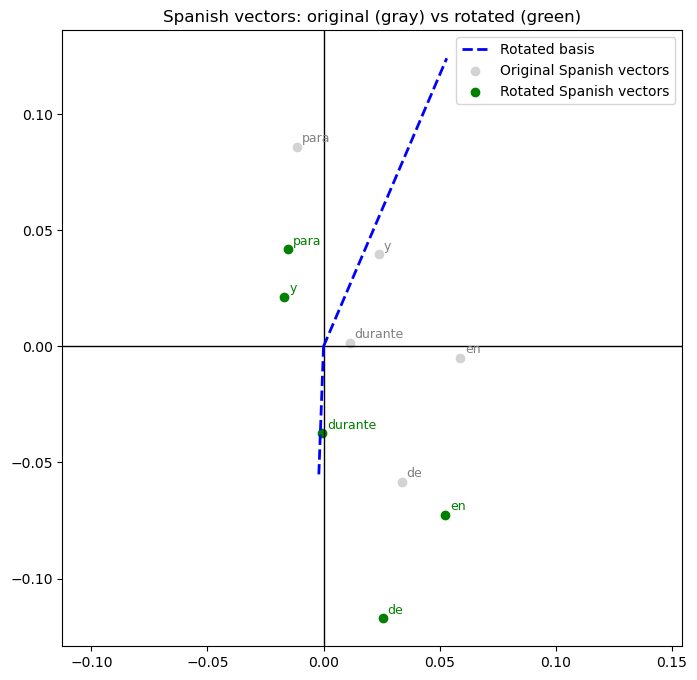

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Assume X_es (d x n) and R (d x d) are already defined
# We take the first 2 dimensions for visualization

fig, ax = plt.subplots(figsize=(8,8))

# Plot original axes (solid black)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Plot rotated basis axes (dotted blue)
origin = np.zeros(2)
for i in range(2):
    vec = R[:2, i]  # first 2 rows of i-th rotated basis vector
    ax.plot([0, vec[0]], [0, vec[1]], 'b--', linewidth=2, label='Rotated basis' if i==0 else "")

# Original Spanish vectors in light gray
X_es_2d = X_es[:2, :].T  # take first 2 rows and transpose to (n_points x 2)
ax.scatter(X_es_2d[:,0], X_es_2d[:,1], color='lightgray', label='Original Spanish vectors')

# Rotated Spanish vectors in green
X_es_rot_2d = (R @ X_es)[:2, :].T  # R @ X_es, take first 2 rows, transpose
ax.scatter(X_es_rot_2d[:,0], X_es_rot_2d[:,1], color='green', label='Rotated Spanish vectors')

# Calculate offset for text labels
x_range = max(X_es_2d[:,0].max(), X_es_rot_2d[:,0].max()) - min(X_es_2d[:,0].min(), X_es_rot_2d[:,0].min())
y_range = max(X_es_2d[:,1].max(), X_es_rot_2d[:,1].max()) - min(X_es_2d[:,1].min(), X_es_rot_2d[:,1].min())
offset = 0.01 * max(x_range, y_range)

# Add labels for original Spanish vectors (light gray)
for i, (_, w_es) in enumerate(pairs):
    ax.text(X_es_2d[i,0]+offset, X_es_2d[i,1]+offset, w_es, color='gray', fontsize=9)

# Add labels for rotated Spanish vectors (green)
for i, (_, w_es) in enumerate(pairs):
    ax.text(X_es_rot_2d[i,0]+offset, X_es_rot_2d[i,1]+offset, w_es, color='green', fontsize=9)

ax.set_aspect('equal', adjustable='datalim')
ax.set_title("Spanish vectors: original (gray) vs rotated (green)")
ax.legend()
plt.show()


### Step 5: Visualize alignment

We reduce embeddings to 2D using PCA to **see the rotation effect**.  

- **Left plot:** English (blue) and Spanish (red) words before rotation → misaligned.  
- **Right plot:** Spanish embeddings after rotation → closely aligned with English.  

Dashed lines connect translation pairs. This illustrates how a **linear isomorphism** can align two spaces.


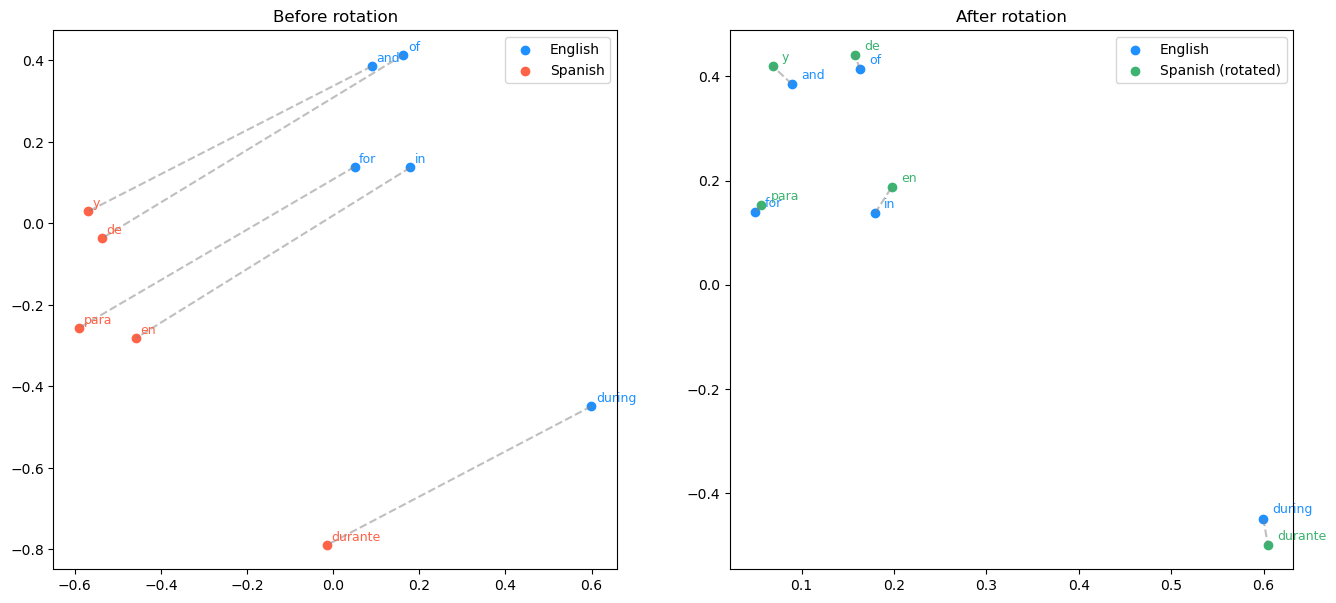

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# X_en, X_es, X_es_aligned are (d × n), with d=300, n=number of word pairs
n_pairs = X_en.shape[1]

# Stack embeddings as columns and transpose to get samples as rows for PCA
all_embeddings = np.hstack([X_en, X_es, X_es_aligned]).T  # shape: (n_words*3, 300)
pca = PCA(n_components=2)
all_2d = pca.fit_transform(all_embeddings)

# Split back into groups
X_en_2d = all_2d[:n_pairs]
X_es_2d = all_2d[n_pairs:2*n_pairs]
X_es_aligned_2d = all_2d[2*n_pairs:]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16,7))

# Before rotation
axes[0].scatter(X_en_2d[:,0], X_en_2d[:,1], color='dodgerblue', label='English')
axes[0].scatter(X_es_2d[:,0], X_es_2d[:,1], color='tomato', label='Spanish')
for i in range(n_pairs):
    axes[0].plot([X_en_2d[i,0], X_es_2d[i,0]], [X_en_2d[i,1], X_es_2d[i,1]], 'gray', linestyle='--', alpha=0.5)
    axes[0].text(X_en_2d[i,0]+0.01, X_en_2d[i,1]+0.01, pairs[i][0], color='dodgerblue', fontsize=9)
    axes[0].text(X_es_2d[i,0]+0.01, X_es_2d[i,1]+0.01, pairs[i][1], color='tomato', fontsize=9)
axes[0].set_title('Before rotation')
axes[0].legend()

# After rotation
axes[1].scatter(X_en_2d[:,0], X_en_2d[:,1], color='dodgerblue', label='English')
axes[1].scatter(X_es_aligned_2d[:,0], X_es_aligned_2d[:,1], color='mediumseagreen', label='Spanish (rotated)')
for i in range(n_pairs):
    axes[1].plot([X_en_2d[i,0], X_es_aligned_2d[i,0]], [X_en_2d[i,1], X_es_aligned_2d[i,1]], 'gray', linestyle='--', alpha=0.5)
    axes[1].text(X_en_2d[i,0]+0.01, X_en_2d[i,1]+0.01, pairs[i][0], color='dodgerblue', fontsize=9)
    axes[1].text(X_es_aligned_2d[i,0]+0.01, X_es_aligned_2d[i,1]+0.01, pairs[i][1], color='mediumseagreen', fontsize=9)
axes[1].set_title('After rotation')
axes[1].legend()

plt.show()


## Demo Observation: "la" → "the"

- **Before rotation:**  
  - L2 distance: 1.0190  
  - Cosine similarity: 0.4808  

- **After rotation:**  
  - L2 distance: 0.8937  
  - Cosine similarity: 0.6007  

### Interpretation

- `"la"` was **not included in the anchor set**, but after applying the Procrustes rotation computed from other function words, it **moved closer** to its English equivalent `"the"`.  
- This illustrates that the **global linear map can improve alignment for nearby words** in the embedding space.  
- Caveat: This doesn’t happen for all words — words far from the anchors (e.g., `"uno"` → `"one"`) may **move farther away**, showing that the method is **exploratory, not a hard guarantee**.  

Key takeaway: Rotation alignment provides a **useful approximation of cross-lingual isomorphism**, but its effect is **anchor-dependent**.


In [49]:
import numpy as np
from scipy.spatial.distance import cosine

# Words to test
tests = [("the", "la")]

for en_w, es_w in tests:
    v_en = en_model[en_w]
    v_es = es_model[es_w]
    
    # Rotate Spanish vector
    v_es_aligned = R @ v_es 
    
    # Compute distances
    l2_before = np.linalg.norm(v_es - v_en)
    l2_after = np.linalg.norm(v_es_aligned - v_en)
    
    cos_before = 1 - cosine(v_es, v_en)
    cos_after = 1 - cosine(v_es_aligned, v_en)
    
    print(f"{es_w} -> {en_w}")
    print(f"  L2 distance before: {l2_before:.4f}, after: {l2_after:.4f}")
    print(f"  Cosine similarity before: {cos_before:.4f}, after: {cos_after:.4f}\n")


la -> the
  L2 distance before: 1.0190, after: 0.8441
  Cosine similarity before: 0.4808, after: 0.6437



In [51]:
import numpy as np
from scipy.spatial.distance import cosine

# Words to test
tests = [("one", "uno"), ("two", "dos")]

for en_w, es_w in tests:
    v_en = en_model[en_w]
    v_es = es_model[es_w]
    
    # Rotate Spanish vector
    v_es_aligned = R @ v_es
    
    # Compute distances
    l2_before = np.linalg.norm(v_es - v_en)
    l2_after = np.linalg.norm(v_es_aligned - v_en)
    
    cos_before = 1 - cosine(v_es, v_en)
    cos_after = 1 - cosine(v_es_aligned, v_en)
    
    print(f"{es_w} -> {en_w}")
    print(f"  L2 distance before: {l2_before:.4f}, after: {l2_after:.4f}")
    print(f"  Cosine similarity before: {cos_before:.4f}, after: {cos_after:.4f}\n")


uno -> one
  L2 distance before: 0.9931, after: 1.1867
  Cosine similarity before: 0.5068, after: 0.2958

dos -> two
  L2 distance before: 0.8944, after: 1.2464
  Cosine similarity before: 0.6000, after: 0.2233



## Cross-Lingual Embedding Alignment with Procrustes: Promise vs. Limits  

### Why it’s explored  
- **Isomorphism hypothesis**: Word embeddings trained separately in different languages often preserve similar geometric structures.  
- **Orthogonal Rotation** offers a way to align them: it finds a rotation that best maps one embedding space onto another.  
- If the hypothesis holds, semantically equivalent words across languages should move closer together after alignment.  
- This method has been used in tasks like **bilingual lexicon induction** and early **unsupervised machine translation**.  

---

### What it demonstrates  
- Using a small set of **anchor pairs** ((of, de),
    (and, y)), we can compute a rotation `R`.  
- Applying `R` aligns the Spanish space to the English one.  
- On average, this reduces the mismatch between equivalent words, though not always for every single pair.  

---

### Why it’s not a guarantee  
- **Global vs. local fit**: The rotation minimizes the *overall* alignment error, so some words may even get farther apart.  
- **Not perfectly isomorphic**: Real language embeddings differ due to training data, polysemy, frequency, and syntax.  
- **Anchor dependence**: Results depend heavily on the quality and number of anchor words used.  
- **Better methods exist**: Modern cross-lingual models (e.g., mBERT, LASER, LaBSE) achieve alignment directly via multilingual training.  

---

### Takeaway  
Rotation alignment is a **worthwhile exploration** and a useful demonstration:  
- It highlights the structural similarity of embedding spaces.  
- It shows how a simple linear map can bridge languages to some extent.  
But it’s not a **hard linguistic law**—more of an approximation that works well in some cases and fails in others.


## How the Choice of Anchors Affects Rotation

- The **rotation** `R` is computed to minimize the total squared distance between the **Spanish vectors you provide** and their corresponding **English vectors**.  
- Only the vectors you choose as anchors directly influence `R`.  

### Consequences for other words
- Any Spanish vector **not in the anchor set** will be rotated using the same `R`.  
- How close it ends up to its English equivalent depends on:
  1. Its **geometric relationship** to the anchors in the Spanish space.
  2. How well the corresponding English vector aligns with the anchors in the English space.
- If a word is “far” from the anchors or the spaces aren’t perfectly isomorphic, the distance to its English counterpart **may increase** after rotation.  

### Takeaways
- Rotation alignment is **highly sensitive to the anchor set**.  
- Adding more diverse, high-quality anchors generally improves global alignment.  
- For small anchor sets, it’s common for some words to get **worse** instead of better.  
- This is why alignment results are usually reported as **average improvements** across many words, not per-word guarantees.
